# Discrete-time quantum walks

This notebook demonstrates the quantum walk for elementary graph configurations. We will explore the quantum walk on a cyclic and a linear graph. You are able to adjust the size of the cyclic and linear graph in this notebook.

Author: Hao Mack Yang (modified from the circle quantum walk)

## Background

A discrete-time random walk on a graph $G$ is a process involving the movement of an agent between various points of the vertex. At each iteration, the agent moves from the current vertex $j$ to a neighboring vertex $k$ with equal probability. The probability distribution is expressed as square vertex $M$ with order the vertex count, defined by

$$
\begin{align*}
    M[j,k] = \begin{cases} 1/\mathrm{outdeg}(j) & \textrm{if edge exists from $j$ to $k$} \\ 0 & \textrm{else}. \end{cases}
\end{align*}
$$

We can initialize this Markov process with any initial probability distribution $\mathbf{p}$ rather than a particular vertex, where $\mathbf{p}[j]$ is the probability the agent will start at a particular vertex $j$. If the agent is initially set to start at a particular vertex $j_0$, then $\mathbf{p}$ is a one-hot vector with unity at the $j_0$ entry.

## Implementation

The input of the algorithm is simply the graph $G = (V, E)$, where $V$ is the set of vertices numbered from $0$ to $N$, while the edges is the set of unordered pairs of vertices $\{j, k\}$ with $j \in 0..N, k \in 0..N, j \neq k$.

The discrete-time quantum walk algorithm consists of iteratively applying two steps, namely the coin flip operator $\hat{C}$ and then the swap operator $\hat{S}$. Although the operation has a high-level description, each graph requires a tailored approach to implementing the quantum walk operation.

The Hilbert space consist of states of the form $|j, k\rangle$ where $\{j, k\} \in E$. The state $|j, k\rangle$ represents a walker at vertex $j$ moving towards vertex $k$, so information is encoded in terms of the directed relations between pairs of vertices. This is not a symmetrical relation, so $|k, j\rangle \neq |j, k\rangle$ in general; you will see both in the swap operator.

In [11]:
# Import necessary hyperparameters
from classiq import *
from math import ceil, log2, log10
from classiq.execution import ExecutionPreferences

# Auxiliary libraries for printing and visualization
import matplotlib.pyplot as plt
import numpy as np
import json
np.set_printoptions(linewidth=65536)

# Specify graph type and size
N = 16          # Number of qubits

# Specify runtime options
SHOTS = 1000000 # Adjust the number of shots to obtain a more accurate result
ITERATIONS = 1  # Number of iterations to run the algorithm

### Auxiliary functions

The diffuzer oracle is applied within preparing the auxiliary qubit to the minus state. This is used to indicate intermediate results. The diffuzer oracle is a phase kickback algorithm which inverts the auxiliary qubit if the target qubit is nonzero. The diffuzer oracle is used in the first step of the quantum walk, the coin flip step gate $C = \sum_{j \in V} |j\rangle \langle j| \otimes (2|\partial_j\rangle \langle\partial_j| - I)$.

The edge oracle applies a bitwise OR to the results qubit in the basis if the vertex nums sum to an odd value. A controlled bitwise swap is then used to apply to the current and adjacent vartex, using the result of the edge oracle as the control bit. The vertex and adjacent are $j$ and $k$ respectively for the formula of the swap step gate $S = \sum_{(j,k) \in E} |j, k\rangle \langle k,j|$.

In [12]:
def next_power_of_two(n: int) -> int:
    """Returns the next power of two after or equal to n. This is an ad-hoc implementation."""
    return 2**ceil(log2(n))

_N = next_power_of_two(N)

@qfunc
def prepare_minus(x: QBit):
    X(x)
    H(x)

@qfunc
def diffuzer_oracle(aux: Output[QNum], x: QNum):
    aux^=(x!=0)

@qfunc
def edge_oracle(res: Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    isconnected = (vertices+adjacent_vertices)%2
    res |= (isconnected == 1)

@qfunc 
def bitwise_swap(x: QArray[QBit], y: QArray[QBit]):
    repeat(count= x.len, iteration= lambda i: SWAP(x[i],y[i]))

# The rest are just for formatting
def _format_string(x: int) -> str:
    if x:
        return "%.3f" % x
    else:
        return "%5s" % "-"

### Connectivity graph and probability

The first step of each quantum walk requires determining the connectivity graph, and then converting it into a probability matrix $M$. For a line of $N$ vertices, for the endpoint vertices, the probability is unity for the one neighbor, and for the $n - 2$ intermediate vertices, the probability is half for the two neighboring vertices.

Four present types of graphs will generated, without the use of an adjacency list or matrix.

In [13]:
def pr_vector_linear(i: int, n: int):
    """Obtain the probability vector of the i-th vertex on the n-th linear graph.
    
    Examples:
        pr_vector_linear(2, 4) = [0, 0.5, 0, 0.5]
        pr_vector_linear(0, 5) = [0, 1, 0, 0, 0]
        pr_vector_linear(2, 3) = [0, 1, 0]
    """
    prob = [0]*n
    if i == 0:
        prob[1] = 1
    elif i == n - 1:
        prob[i - 1] = 1
    else:
        prob[i - 1] = 0.5
        prob[i + 1] = 0.5
    return prob

def pr_vector_cyclic(i: int, n: int):
    """Obtain the probability vector of the i-th vertex on the n-th cyclic graph.
    
    Examples:
        pr_vector_cyclic(2, 4) = [0.0, 0.5, 0, 0.5]
        pr_vector_cyclic(0, 5) = [0, 0.5, 0, 0, 0.5]
        pr_vector_cyclic(2, 3) = [0.5, 0.5, 0]
    """
    prob = [0]*n # AD-HOC: Array must be a power of two
    prob[(i+1)% n]=0.5
    prob[(i-1)% n]=0.5
    return prob

def pr_vector_star(i: int, n: int):
    """Obtain the probability vector of the i-th vertex on the (n-1)-th star graph.
    The zeroth vertex is the center of the star.
    
    Examples:
        pr_vector_cyclic(2, 4) = [1, 0, 0, 0]
        pr_vector_cyclic(0, 5) = [0, 0.25, 0.25, 0.25, 0.25]
        pr_vector_cyclic(2, 3) = [1, 0, 0]
    """
    prob = None # AD-HOC: Array must be a power of two
    if i == 0:
        return [0] + [1/(n - 1)]*(n - 1)
    else:
        return [1] + [0]*(n - 1)

def pr_vector_complete(i: int, n: int):
    """Obtain the probability vector of the i-th vertex on the n-th complete graph.
    
    Examples:
        pr_vector_cyclic(2, 4) = [0.33, 0.33, 0, 0.33]
        pr_vector_cyclic(0, 5) = [0, 0.25, 0.25, 0.25, 0.25]
        pr_vector_cyclic(2, 3) = [0.5, 0.5, 0]
    """
    prob = [1/(n - 1)]*n
    prob[i] = 0
    return prob

# Define the graph type here
h = pr_vector_linear

### Coin flip operator

Using the probability vector, which can easily be obtained as a function and if-statements for linear and cyclic cases, we can use the zero diffuzer to implement the diffuzer oracle required for realizing $|\partial_j\rangle\langle\partial_j|$. Using this schema for the Hilbert space, there exists a unitary $U_j$ over the input _and_ auxiliary qubits such that $U_j|j\rangle = |\partial_j\rangle$, allowing us to reduce the diffusion into a zero diffusion problem $(2| \partial_j \rangle\langle \partial_j | - I) = U_j (2| 0 \rangle\langle 0 | - I) U_j^{\dagger}$.

The $C$ gate uses the controlled diffuzer oracle under the minus state to apply to the adjacent vertex index.

As `C_iteration` loops through each vertex, it also outputs the probability vectors. The matrix $M$ will be printed out during the `C_operator`'s runtime.

In [14]:
@qfunc
def zero_diffuzer(x: QNum):
    """Perform the zero diffuzer. The oracle can simply be implemented in terms of arithmetic in Classiq.
    Thus, it can perform the phase kickback using the unitary as a conjugation."""
    aux = QNum('aux')
    allocate(1,aux)
    within_apply(within=lambda: prepare_minus(aux),
                 apply=lambda: diffuzer_oracle)

def C_iteration(j: int, vertices: QNum, adjacent_vertices: QNum):
    """Perform the C operation for one vector, represented as a controlled zero diffuzer operation
    with the vertices as the control, and the adjacent_vertices as the target. The C iteration applies
    to all vertices in the graph.
    
    Please note that internally, the probability vector must have size a power of two. Extra states
    are made inaccessible by padding the transition probabilities to nil.
    """
    # This line represents the graph we will use, and will be used as control for the zero diffuzer.
    prob = h(j, N) + [0]*(_N - N)
    # Should print out the matrix
    print('State={1:{0:d}d}, prob vec ={2:s}'.format(ceil(log10(N - 1) + 1), j, np.array2string(np.array(prob), formatter={'float_kind':lambda x: _format_string(x), 'int':lambda x: _format_string(x)})))
    
    # Perform the C operation for this particular vertex, 
    # encoded as a controlled zero diffuzer operation controlled by prob.
    control(ctrl = vertices==j, 
            stmt_block = lambda: within_apply(
                within = lambda: inplace_prepare_state(probabilities=prob, 
                                                       bound=0.01, 
                                                       target=adjacent_vertices),
                apply  = lambda: zero_diffuzer(adjacent_vertices)))

@qfunc 
def C_operator(vertices: QNum, adjacent_vertices: QNum):
    """Classiq qfunc for applying the C iteration to each vertex.
    Extraneous states from remainders after rounding up to nearest power of two 
    will not get C_iterations."""
    for i in range(N):
        C_iteration(i, vertices, adjacent_vertices)

### Swap operator

The second step of the quantum walk function is to perform the swap operator. The swap operator is simply the normalized sum of all operators of connected vertices $|j,k \rangle \langle k,j|$. Notice that $|j,k \rangle \neq \langle k,j|$ in general.

In [15]:
@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    """Classiq qfunc for performing the bitwise swap between this vertex and the neighboring vertex,
    provided that the two vertices are connected."""
    res = QNum('res')
    edge_oracle(res, vertices, adjacent_vertices)
    control(ctrl = res == 1,
            stmt_block = lambda: bitwise_swap(vertices, adjacent_vertices))

## Driver code

We run that many iterations of the quantum walk algorithm, starting with the equal superposition state.

In [16]:
_SIZE = int(ceil(log2(N)))

@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):
    # Allocate two sets of vertices as qubits. 
    allocate(_SIZE, vertices)
    allocate(_SIZE, adjacent_vertices)
    hadamard_transform(vertices) # Still only fully works for powers of two, we can discard extras
    print("Allocated two sets of %d qubits for a %d vertex graph." % (_SIZE, N))

    # Perform quantum step iteration
    for k in range(ITERATIONS):
        print("Running iteration %d…" % (k + 1))
        C_operator(vertices,adjacent_vertices)
        S_operator(vertices,adjacent_vertices)
    
    print("Finished running quantum walk.")

Finally, we create the model, set the constraints (for simulator compatibility) and set the execution preferences. Please note some simulators are limited to very small qubit counts, meaning the depth can be great for such a limited number of auxiliary qubits. Already at 17 - 32 vertices we need to have 43 qubits to implement!

Please note the synthesis step may take a long time with both high width and depth count, and the visualization may fail. We will save a Qasm version of the circuit.

In [17]:
_QUBIT_LIMIT = 25

# Create and optimize model
print("Creating and optimizing model…")
qmod = create_model(main)
qmod = set_constraints(qmod, Constraints(optimization_parameter="depth", max_width=_QUBIT_LIMIT))

qmod = set_execution_preferences(qmod, 
           ExecutionPreferences(num_shots=SHOTS, 
                                job_name="quantumwalk_L{0:d}".format(N),
                                #transpile_to_hardware='intensive'
                               ))

qmod = set_preferences(qmod, Preferences(output_format=["qasm"], timeout_seconds=65536))

# Synthesize model
print("Synthesizing model…")
qprog = synthesize(qmod)

Creating and optimizing model…
Allocated two sets of 4 qubits for a 16 vertex graph.
Running iteration 1…
State=  0, prob vec =[    - 1.000     -     -     -     -     -     -     -     -     -     -     -     -     -     -]
State=  1, prob vec =[0.500     - 0.500     -     -     -     -     -     -     -     -     -     -     -     -     -]
State=  2, prob vec =[    - 0.500     - 0.500     -     -     -     -     -     -     -     -     -     -     -     -]
State=  3, prob vec =[    -     - 0.500     - 0.500     -     -     -     -     -     -     -     -     -     -     -]
State=  4, prob vec =[    -     -     - 0.500     - 0.500     -     -     -     -     -     -     -     -     -     -]
State=  5, prob vec =[    -     -     -     - 0.500     - 0.500     -     -     -     -     -     -     -     -     -]
State=  6, prob vec =[    -     -     -     -     - 0.500     - 0.500     -     -     -     -     -     -     -     -]
State=  7, prob vec =[    -     -     -     -     -     - 0.5

In [18]:
circuit = QuantumProgram.from_qprog(qprog)
print("Width: %d" % circuit.data.width)
print("Depth: %d" % circuit.transpiled_circuit.depth)
print("Count: %s" % str(circuit.transpiled_circuit.count_ops))

# Show and save program
f = open("haomackyang_lee_hw4_%d-%d.qasm" % (N, ITERATIONS), "w")
f.write(json.loads(qprog).get("outputs").get("qasm"))
f.close()
show(qprog)

Width: 25
Depth: 1906
Count: {'u': 1782, 'cx': 1683}
Opening: https://platform.classiq.io/circuit/52260599-6335-4470-9874-fd876d1391ac?version=0.46.0


### Running the code

Finally, we execute the code on the simulator. The printout is a list of all measured visiting states; either the `vertices` or `adjacent_vertices` are nonzero, if the destination is nonzero.

In [19]:
# Run the model. Note the job will throw an exception if the number of qubits exceeds the limit of 25.
job = execute(qprog)
results = job.result()[0].value.parsed_counts

# Print out and graph results
frequency = [0]*_N
for sampledstate in results:
    print(sampledstate)
    dest = int(max(sampledstate.state['vertices'], sampledstate.state['adjacent_vertices']))
    frequency[dest] = sampledstate.shots

state={'vertices': 0.0, 'adjacent_vertices': 0.0} shots=1000000


# Discussion

Consistent to our expectations, for any starting vertex, after performing many random walk steps on a linear graph, we expect that the agent is equally likely to be at any other vertex except a slightly higher value for the second and second last vertex.

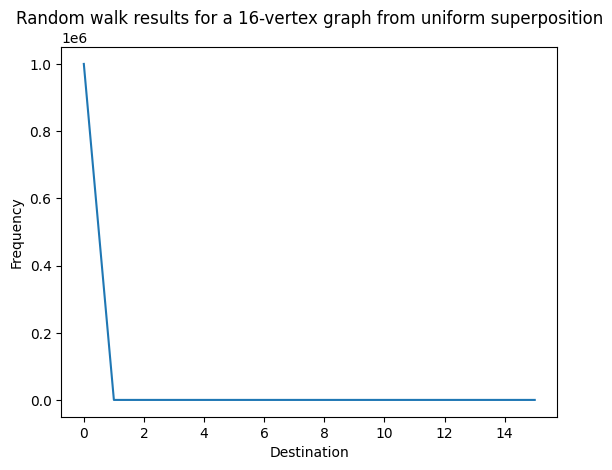

In [20]:
# Graph out results
plt.title("Random walk results for a %d-vertex graph from uniform superposition" % N)
plt.xlabel("Destination")
plt.ylabel("Frequency")
plt.plot(np.linspace(0, _N-1, _N), frequency)

```markdown
Made with <3 with GitHub Copilot
```